In [9]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import xarray
import cartopy.crs as ccrs
from scipy.signal import detrend
from eofs.xarray import Eof
import iris
from eofs.multivariate.iris import MultivariateEof
import iris.quickplot as qplt

In [10]:
variable_mslp = ["PRMSL_GDS0_MSL","mslp"]
variable_rh = ["RH_GDS0_ISBL","rh"]
variable_spfh = ["SPFH_GDS0_ISBL","spfh"]
pfad = "data/"

In [11]:
def open_df(pfad):
    df = xr.open_mfdataset(pfad+'/*.nc',chunks={'initial_time0_hours':504,'g0_lat_1':29,'g0_lon_2':29})
    df = df.rename({'initial_time0_hours':'time','g0_lat_1':'lat','g0_lon_2':'lon'}).drop("initial_time0_encoded")
    df.coords['lon'] = (df.coords['lon'] + 180) % 360 - 180
    return df
def pref_df(ds_prep,window_size):
        ds_prep = ds_prep.resample(time='1D').mean()
        ds_prep = ds_prep.chunk({'time':-1})
        ds_prep_roll = ds_prep.rolling(time=window_size, center=True).construct('window_dim')
        ds_prep_clim = ds_prep_roll.groupby('time.dayofyear').mean(dim=['window_dim','time'])
        ds_prep_std = ds_prep_roll.groupby('time.dayofyear').std(dim=xr.ALL_DIMS)
        ds_prep = ds_prep.groupby('time.dayofyear') - ds_prep_clim
        ds_prep = ds_prep.groupby('time.dayofyear') / ds_prep_std
        ds_prep = ds_prep.chunk({'time': -1})
        return ds_prep

In [12]:
df = open_df(pfad)
df = df.rename({variable_mslp[0]:variable_mslp[1],variable_rh[0]:variable_rh[1]
                variable_spfh[0]:variable_spfh[1]}).drop("initial_time0")
df = pref_df(df,21)

In [13]:
df

<xarray.Dataset>
Dimensions:    (lat: 29, lon: 29, time: 1461)
Coordinates:
  * lat        (lat) float32 67.5 66.25 65.0 63.75 ... 36.25 35.0 33.75 32.5
  * lon        (lon) float32 -10.0 -8.75 -7.5 -6.25 ... 21.25 22.5 23.75 25.0
  * time       (time) datetime64[ns] 1958-01-01 1958-01-02 ... 1961-12-31
    dayofyear  (time) int64 dask.array<shape=(1461,), chunksize=(1461,)>
Data variables:
    mslp       (time, lat, lon) float32 dask.array<shape=(1461, 29, 29), chunksize=(1461, 29, 29)>
    rh         (time, lat, lon) float32 dask.array<shape=(1461, 29, 29), chunksize=(1461, 29, 29)>
    spfh       (time, lat, lon) float32 dask.array<shape=(1461, 29, 29), chunksize=(1461, 29, 29)>

In [14]:
df_roll = df.rolling(time=21,center=True).construct("window_dim")

In [63]:
vars_list = []
eofs_list = []
pcs_list = []
evs_list = []

l = 0

for day in df_roll.groupby("time.dayofyear"):
    cube = day[1].rename({"time":
                          "time_old"}).stack(time = ("time_old",
                                                            "window_dim")).reset_index("time").transpose("time",
                                                                                                         "lat",
                                                                                                         "lon").dropna("time")
    cube_mslp = cube.mslp.assign_coords(time=range(0,len(cube.time))).to_iris()
    cube_rh = cube.rh.assign_coords(time=range(0,len(cube.time))).to_iris()
    solver = MultivariateEof([cube_mslp,cube_rh],weights="coslat")
    
    var = 0
    i = 1
    var_list = []
    while var<=0.9:
        v = solver.varianceFraction(neigs=i)
        var = v.data.sum()
        var_list += [var]
        i += 1
    
    vars_list += [var_list]
    eofs_list += [solver.eofs(neofs=i-1)[0]]
    pcs_list += [solver.pcs(npcs=i-1)]
    evs_list += [solver.eigenvalues(neigs=i-1)]
    
    l += 1
    
    if l == 3:
        break

In [64]:
i

26

In [65]:
eofs_list

[<iris 'Cube' of empirical_orthogonal_functions / (unknown) (eof_number: 25; latitude: 29; lon: 29)>,
 <iris 'Cube' of empirical_orthogonal_functions / (unknown) (eof_number: 25; latitude: 29; lon: 29)>,
 <iris 'Cube' of empirical_orthogonal_functions / (unknown) (eof_number: 25; latitude: 29; lon: 29)>]

In [66]:
pcs_list

[<iris 'Cube' of principal_components / (unknown) (time: 74; pc_number: 25)>,
 <iris 'Cube' of principal_components / (unknown) (time: 75; pc_number: 25)>,
 <iris 'Cube' of principal_components / (unknown) (time: 76; pc_number: 25)>]

In [67]:
evs_list

[<iris 'Cube' of eigenvalues / (unknown) (eigenvalue_number: 25)>,
 <iris 'Cube' of eigenvalues / (unknown) (eigenvalue_number: 25)>,
 <iris 'Cube' of eigenvalues / (unknown) (eigenvalue_number: 25)>]

In [70]:
vars_list

[[0.2393817,
  0.36350918,
  0.4436077,
  0.51328325,
  0.57874995,
  0.6233544,
  0.66166157,
  0.68928623,
  0.7129274,
  0.73488665,
  0.75489426,
  0.7724559,
  0.78784966,
  0.8021059,
  0.81472,
  0.82625383,
  0.83689886,
  0.8468558,
  0.8562296,
  0.86488,
  0.8733104,
  0.88034004,
  0.88731855,
  0.89393985,
  0.9003605],
 [0.23718588,
  0.37137413,
  0.44868883,
  0.5206412,
  0.5823832,
  0.62903976,
  0.66608524,
  0.6919333,
  0.7156405,
  0.7371027,
  0.7566246,
  0.7734418,
  0.7875813,
  0.8016053,
  0.8144645,
  0.8256464,
  0.83610225,
  0.8460052,
  0.8553104,
  0.86389136,
  0.87216806,
  0.88020986,
  0.8879776,
  0.89452016,
  0.90090406],
 [0.23182446,
  0.3747436,
  0.44913125,
  0.52242833,
  0.58473486,
  0.63014734,
  0.6659026,
  0.692611,
  0.7167016,
  0.7386468,
  0.7576325,
  0.7739552,
  0.7895983,
  0.80367005,
  0.8163301,
  0.8269446,
  0.8373766,
  0.84695786,
  0.8561619,
  0.86531156,
  0.873384,
  0.88131785,
  0.8890024,
  0.8957608,
  0.90180

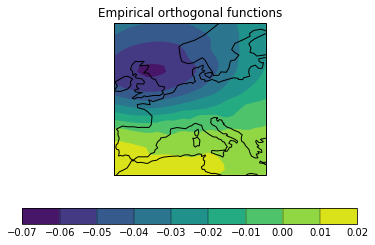

In [71]:
plt.axes(projection=ccrs.PlateCarree())
qplt.contourf(eofs_list[0][0])
plt.gca().coastlines()
plt.show()